# Groundwater level data exploration

The aim here is to explore the raw data of the groundwater levels in the Lower Saxony State in Germany. 

In [1]:
#Import libraries
%matplotlib notebook
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
from functions import *
import warnings
import contextily as cx
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from IPython.display import Markdown as md
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
rpath="D:/Data/students/mariana/data/" #Root path

## Selection criteria
There is a pre-selection of well stations based on the "climatic hydrograph" method (agreement between the theoretical and observed hydrograph) and a proposal list from previous projects (KIT-BGR). The assessment contains subjective components, based on past analyses. This selection exclude wells under strong anthropogenic incluences such as pumping, allowing to assure a dependencz between the climatic input variables and the groundwater data.

In [4]:
#Import Groundwatwer stations
GW_CD_ID= gpd.read_file(rpath+"SHP/GWL_CDID.shp")
GW_CD_sel=GW_CD_ID[GW_CD_ID.KLIGL_GRUP.isin([1,12,13])] # selection of stations in good agreement with climatic variables


In [5]:
total_wells= GW_CD_ID.shape[0]
sel_wells= GW_CD_sel.shape[0]
md(f"The data consists of a total of {total_wells} wells. \
   <br> After excluding the wells under anthropogenic influence:  {sel_wells} wells.")

The data consists of a total of 962 wells.    <br> After excluding the wells under anthropogenic influence:  745 wells.

### Load groundwater level data according to criteria

In [6]:
gwlist=[]
gidlist=[]
for gid in GW_CD_sel.MEST_ID : # Load data from selected IDs
    gw=readGWdata(gid,rpath +"/Grundwasserstandsdaten/Einzelmessstellen/")
    gwlist.append(gw)
    gidlist.append(gid)
    nonan=gw.GW_NN.count()
    index=GW_CD_sel.loc[GW_CD_sel.MEST_ID==gid].index.values[0]
    GW_CD_sel.loc[index, "nonan"]=nonan
gwdata_dic={"wellid":gidlist, "data":gwlist}

#Dataframe containing all the well information available
gwdata=pd.DataFrame(gwdata_dic)

##Save groundwater data
#gwdata.to_pickle(rpath+"/data/Pickle/gwdata.pkl") 

##  Time range

This is used as a spatial overview of the data length

In [7]:
#Load groudnwater data
gwdata= pd.read_pickle(rpath+"Pickle/gwdata.pkl")

#Convert monthly measurements to annual assuming no gaps to check the time series length
#GW_CD_sel["nonan_yr"]=GW_CD_sel["nonan"]/12

<IPython.core.display.Javascript object>


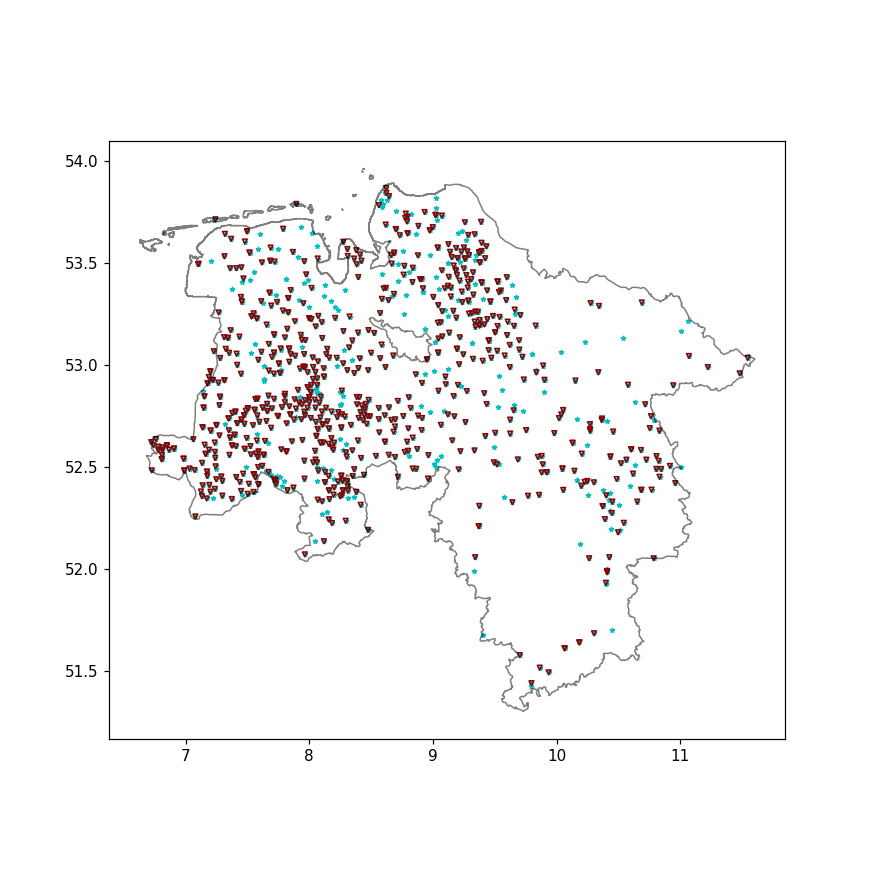

<AxesSubplot:>

In [16]:
#Plot GW stations with data information - INICIAL VISUALIZATION
germany_states = gpd.read_file(rpath+"/SHP/DEU_adm1.shp")
NS=germany_states[germany_states.NAME_1== "Niedersachsen"]
GW_CD_ID=GW_CD_ID.to_crs(epsg=4326)
GW_CD_sel=GW_CD_sel.to_crs(epsg=4326)
NSmap= NS.boundary.plot( figsize=(8, 8), alpha=0.5, edgecolor='k', linewidth=1)
GW_CD_ID.plot(ax=NSmap,marker='*', color='c', markersize=8, label="GW")
GW_CD_sel.plot(ax=NSmap,markersize=10, marker="v", facecolor="None",legend=True, color="darkred", label="GW_sel")



## Gaps length

Check the gap lengths to define the interpolation method

In [8]:
#Load groundwater saved data
gwdata= pd.read_pickle(rpath+"Pickle/gwdata.pkl")

gaps_list=[]
count=[]
for i in range(sel_wells):
    gwdatam=gwdata.data[i].dropna(subset='GW_NN', inplace=False)#Drop nan values 
    deltas=gwdatam["DATUM"].diff()[1:]
    gaps = deltas[deltas > dt.timedelta(days=31)]
    gaps_list.append(gaps)
    count.append(len(gaps))
    
gwdata["count"]=count
gwdata["gaps"]=gaps_list
gwdata["max_gap"]=gwdata.gaps.apply(lambda x: x.max().days)

In [9]:
#Estimate gap interval in days and months - 2 months means 1 missing data
gwdata["max_gap"]=gwdata.gaps.apply(lambda x: x.max().days)
gwdata["max_gap_months"]=gwdata.gaps.apply(lambda x: x.max().days/30)

In [10]:
gwdata['max_gap'] = gwdata['max_gap'].replace(np.nan, 0)
gwdata['max_gap_months'] = gwdata['max_gap_months'].replace(np.nan, 0)

In [11]:
gwdatasort0=gwdata.copy()
gwdatasort=gwdatasort0.sort_values(by="max_gap", ascending=False).reset_index(drop=True)

In [12]:
gwdatasort.max_gap_months.loc[gwdatasort.max_gap_months.isnull()]=0

<IPython.core.display.Javascript object>


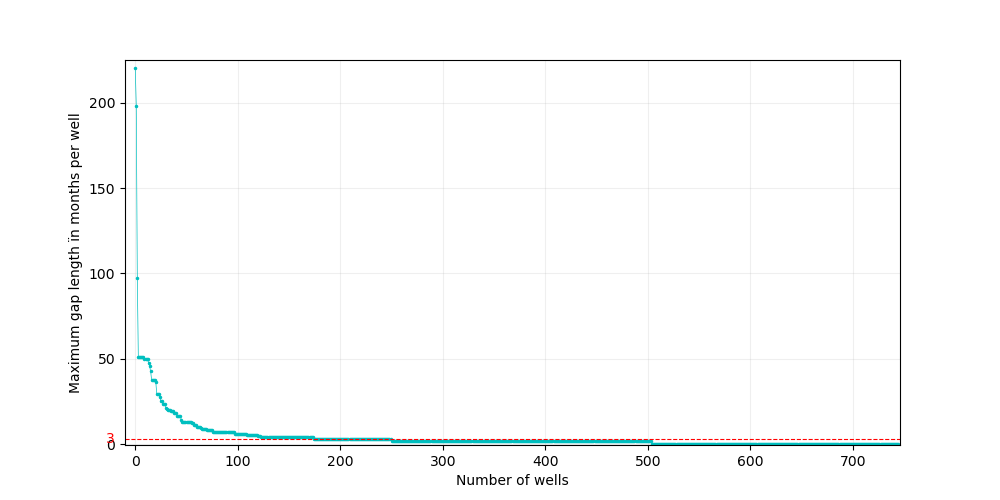

In [13]:
#Plot the maximum gap (in months) 
thresh=3 #Maximum number of gap length allowed
fig, ax = plt.subplots(figsize=(10,5))
data=gwdata.sort_values(by="max_gap_months")
plt.plot(gwdatasort.index, gwdatasort["max_gap_months"], marker='.', markersize=3, color="c", lw=0.5)
ax.set_ylabel("Maximum gap length ïn months per well")
ax.set_xlabel("Number of wells")
ax.set_ylim(-0.5,int(gwdatasort["max_gap_months"].max())+5)
ax.set_xlim(-10,len(gwdatasort)+1)
plt.axhline(y=thresh, color="r", linestyle="--", lw="0.8", xmin=0, xmax=len(gwdatasort))

trans= transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
plt.text(0,thresh,"{:.0f}".format(thresh), color="r", transform=trans, ha="right", va="center")

plt.grid(True, alpha=0.2)

<IPython.core.display.Javascript object>


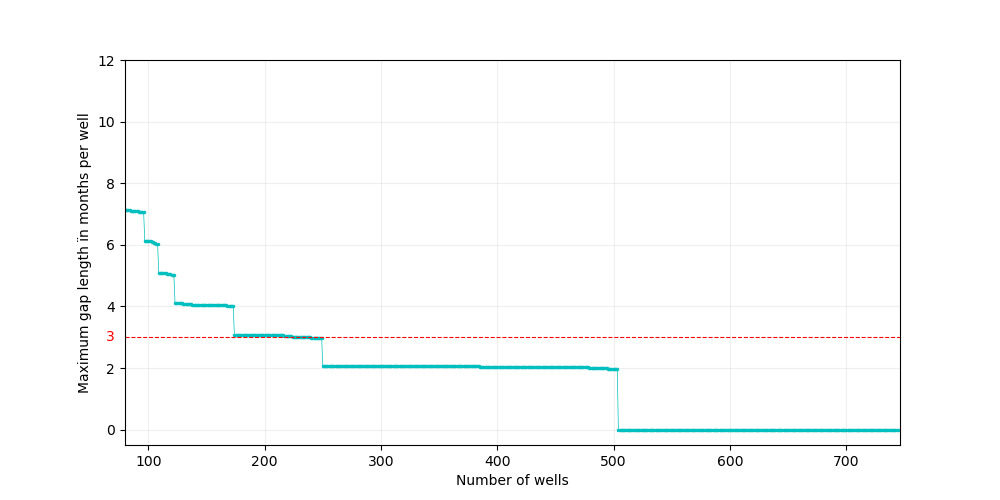

In [14]:
#CLOSER VIEW
thresh=3 #Maximum number of gap length allowed
fig, ax = plt.subplots(figsize=(10,5))
data=gwdata.sort_values(by="max_gap_months")
plt.plot(gwdatasort.index, gwdatasort["max_gap_months"], marker='.', markersize=3, color="c", lw=0.5)
ax.set_ylabel("Maximum gap length ïn months per well")
ax.set_xlabel("Number of wells")
ax.set_ylim(-0.5,12)
ax.set_xlim(80,len(gwdatasort)+1)
plt.axhline(y=thresh, color="r", linestyle="--", lw="0.8", xmin=0, xmax=len(gwdatasort))

trans= transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
plt.text(0,thresh,"{:.0f}".format(thresh), color="r", transform=trans, ha="right", va="center")

plt.grid(True, alpha=0.2)

In [15]:
#Descriptive statistics
gwdata.max_gap_months.describe()

count    745.000000
mean       4.621834
std       13.691166
min        0.000000
25%        0.000000
50%        2.066667
75%        3.066667
max      220.200000
Name: max_gap_months, dtype: float64

<IPython.core.display.Javascript object>


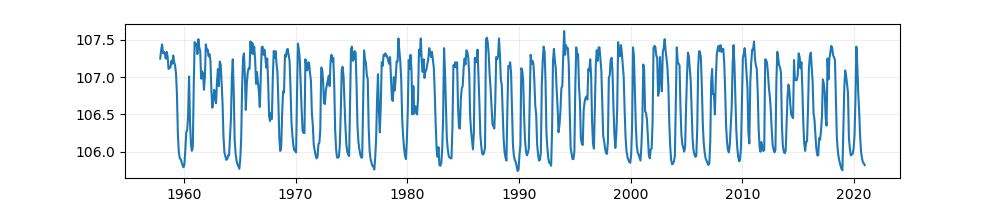

In [16]:
gwwell=gwdata.data[35]
Fig= plt.figure(figsize=(10,2))
plt.plot(gwwell["DATUM"], gwwell["GW_NN"])
plt.grid(True, alpha=0.2)

### Remove data with gaps longer than 3 months

In [17]:
gw_gapsel=gwdata[gwdata["max_gap"]<30*3]
gw_gapsel.shape
#Save selected gw data
#gw_gapsel.to_pickle(rpath+"/Pickle/gwsel.pkl") 

(505, 6)

In [19]:
GW_gapsel

,MEST_ID,MS_LBEZ,MS_MSA_ID,UTM_X,UTM_Y,MS_EIG,MS_BTR,MS_GOKNN,MS_FOK,MS_FUK,BGR_NSE_R2,BGR_REFERE,KLIGL_GRUP,AUSWAHL_KL,AUSWERTUNG,CD_ID_1,CD_ID_2,geometry
1,9610009,Stollhamm,GWM,32457786.19,5930528.14,OOWV,NLWKN Brake-Oldenburg,1.20,19.20,20.20,Y,N,1,Y,KLIMGL_30JAHRE_1987_2017,2551,1223.0,POINT (8.36327 53.52198)
4,9610749,Delmenhorst-Langenwisch,GWM,32478507.19,5877458.91,Land Niedersachsen,NLWKN Brake-Oldenburg,6.19,19.60,21.60,N,N,1,Y,KLIMGL_30JAHRE_1987_2017,2841,1319.0,POINT (8.67940 53.04621)
5,9610863,Wangerooge,GWM,32427238.76,5960706.55,OOWV,NLWKN Brake-Oldenburg,5.05,18.75,22.45,Y,N,1,Y,KLIMGL_30JAHRE_1987_2017,1957,1026.0,POINT (7.89552 53.78985)
7,9610875,Dykhausen,GWM,32431001.83,5929353.97,Land Niedersachsen,NLWKN Brake-Oldenburg,0.89,6.00,7.00,N,N,1,Y,KLIMGL_30JAHRE_1987_2017,1951,1023.0,POINT (7.95959 53.50860)
10,9610901,Osterforde,GWM,32434695.15,5914734.74,Land Niedersachsen,NLWKN Brake-Oldenburg,7.30,5.69,6.90,N,N,12,Y,KLIMGL_30JAHRE_1987_2017,2048,1022.0,POINT (8.01830 53.37768)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,40502600,Papenburg,GWM,32393594.98,5879586.74,NLWKN_MEPPEN,NLWKN_MEPPEN,6.13,27.20,36.20,None,None,1,Y,KLIMGL_20JAHRE_1997_2017_208_128,1242,620.0,POINT (7.41240 53.05518)
927,100000609,Barlissen (482/34),GWM,32555385.09,5698980.74,NLWKN,NLWKN,279.22,43.00,53.00,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,4306,1803.0,POINT (9.79686 51.43931)
929,100003869,Groß Ellershausen 2,GWM,32559933.39,5707490.30,NLWKN,NLWKN,222.50,37.70,51.70,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,4408,1804.0,POINT (9.86373 51.51535)
946,9700203,Osterlindern 7/1,GWM,32419467.64,5857189.89,NLWKN,69,38.86,36.00,38.00,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,1737,818.0,POINT (7.80389 52.85841)


In [18]:
GW_gapsel=GW_CD_sel[GW_CD_sel["MEST_ID"].isin(gw_gapsel["wellid"])]
GW_gapsel.shape
##Save grounwater stations filtered by gaps
#GW_gapsel.to_file(rpath+"/SHP/GWF2.shp")

(505, 19)

### Plot data availability

In [19]:
#Sort stations by latitude
gwgpd=GW_CD_sel.sort_values(by="UTM_Y").reset_index() 


In [20]:
#set dataframes to check the start and end of the well observation
c=0
df0=[]
df1=[]
for idv in gwgpd.MEST_ID:
    datawell=gw_gapsel.loc[gw_gapsel.wellid==idv].reset_index()
    if not datawell.empty:
        datwell= datawell.iloc[0].data
        data0=datwell.copy()
        data0.GW_NN.loc[~data0.GW_NN.isnull()]=c
        data1=datwell.copy()
        data1.GW_NN=c

        df0.append(data0)
        df1.append(data1)

        c+=1

In [21]:
li=[]
lf=[]
for df in df0:
    ivalid=df.GW_NN.first_valid_index()
    fvalid=df.GW_NN.last_valid_index()
    yri=df.DATUM[ivalid].year
    yrf=df.DATUM[fvalid].year
    li.append(yri)
    lf.append(yrf)
print()

In [22]:
max(lf)

md(f"The groundwater observations are available from {min(li)} until {max(lf)}. \
   But in general, the time range is highly variable")

The groundwater observations are available from 1950 until 2021.    But in general, the time range is highly variable

<IPython.core.display.Javascript object>


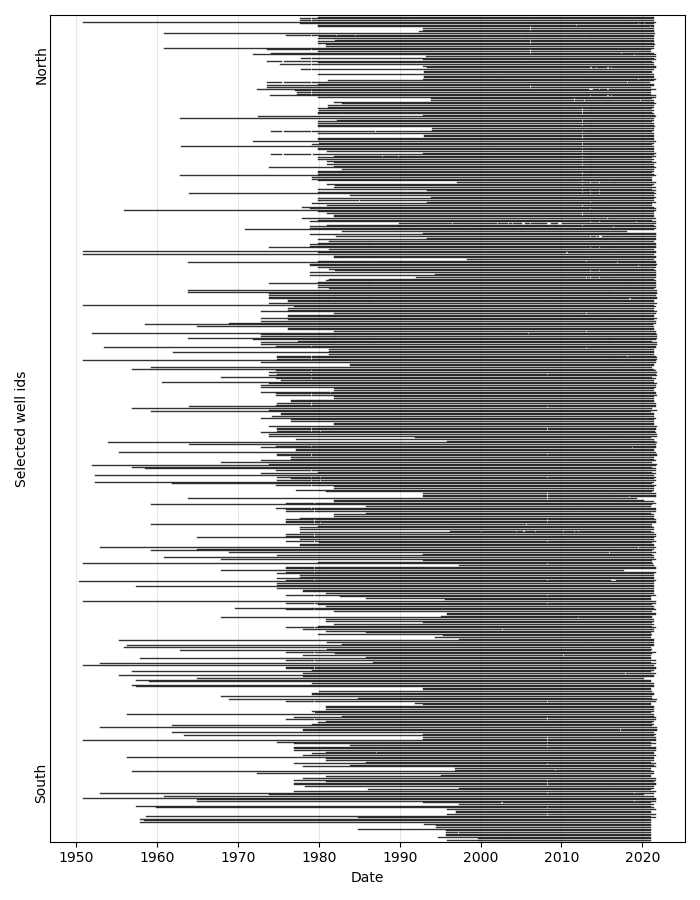

In [42]:
##Plot data availability after remove series with gap lenghts above 3 months. 

fig, ax = plt.subplots(figsize=(7,9))
for i in range(len(gw_gapsel)):
    #plt.plot(df1[i].DATUM,df1[i].GW_NN, c="r",lw=1)
    ax.plot(df0[i].DATUM,df0[i].GW_NN, c="k",lw=1, alpha=0.8)
ax.set_ylim(0,len(gw_gapsel))
ax.set_xlabel("Date")
ax.set_ylabel("Selected well ids", labelpad=15)
ax.grid(True, alpha=0.3, axis="x")
trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
ann = ax.annotate('North', xy=(-9200, 0.92), xycoords=trans, rotation=90)
ann2 = ax.annotate('South', xy=(-9200, 0.05), xycoords=trans, rotation=90)
ax.tick_params(axis='y',which='both',      
    left=False, labelleft=False, right=False) # labels along the bottom edge are off

plt.tight_layout()

## Plot data after filter

<IPython.core.display.Javascript object>


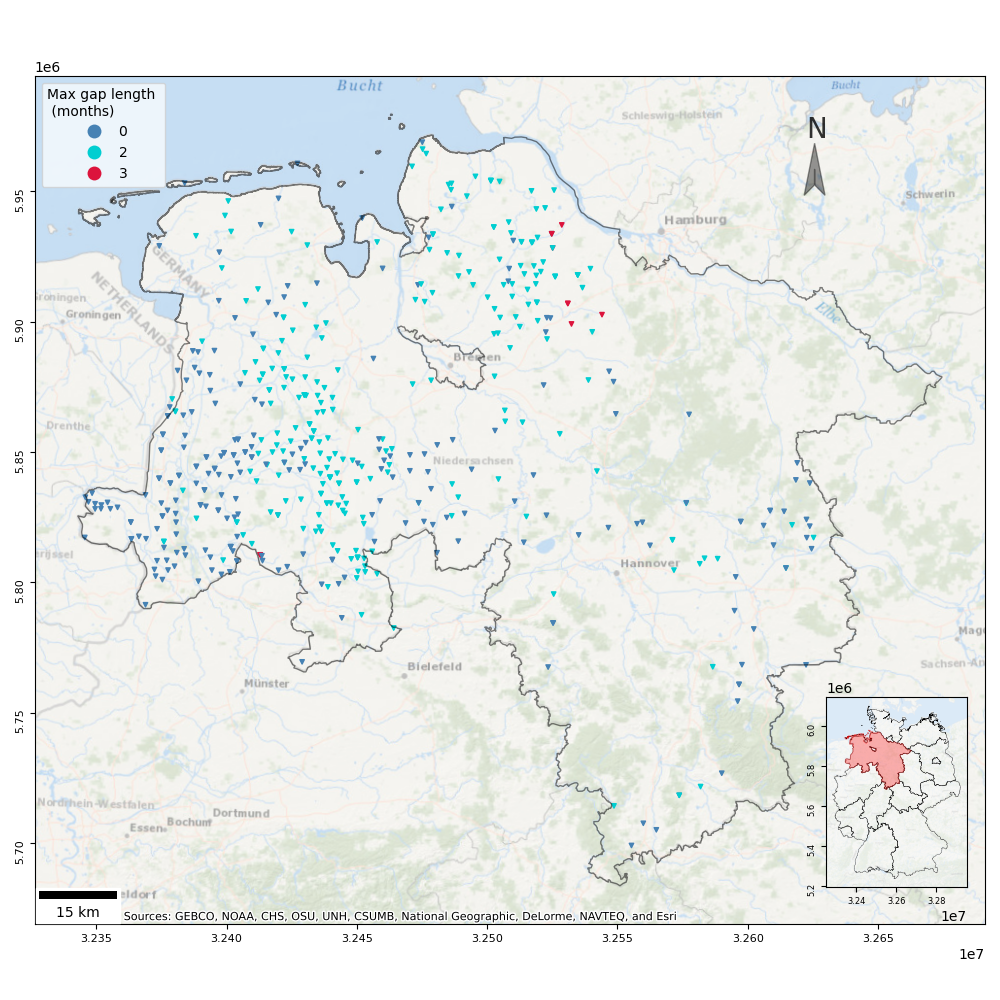

In [29]:
#Plot GW stations with data information
germany_states = gpd.read_file(rpath+"/SHP/DEU_adm1.shp")
germany_st=germany_states.to_crs(GW_gapsel.crs.to_string())
GW_gapsel["max_gap"]=gw_gapsel.max_gap.values
GW_gapsel["max_gap_month"]=gw_gapsel.max_gap_months.values.round().astype(int)

NS=germany_st[germany_states.NAME_1== "Niedersachsen"]
#GW_CD_ID=GW_CD_ID.to_crs(epsg=4326)
#GW_gapsel=GW_gapsel.to_crs(epsg=4326)

#Set pallete for unique values
pallete = {2: 'steelblue', 0: 'darkturquoise', 3 : 'crimson'}
cmap = mcolors.ListedColormap([pallete[b] for b in GW_gapsel.max_gap_month.unique()])

gw=GW_gapsel.plot(figsize=(10, 10),column="max_gap_month",categorical=True, markersize=10,
               marker="v", facecolor="None",cmap=cmap, legend=True,legend_kwds={'loc': 'upper left', 'framealpha': 0.7})
NS.boundary.plot( ax=gw, alpha=0.5, edgecolor='k', linewidth=1)

leg = gw.get_legend()
#legend = plt.legend( loc=4, fontsize='small', fancybox=True)
leg.set_title("Max gap length \n (months)")   

#Scale bar
scalebar = ScaleBar(0.5, "m", dimension="si-length", length_fraction=0.10, location="lower left")
gw.add_artist(scalebar)

gw.tick_params(axis='y', which='major', labelsize=8, rotation=90)
gw.tick_params(axis='x', which='major', labelsize=8, rotation=0)


startx, endx = gw.get_xlim()
starty, endy = gw.get_ylim()


#Location map
locbox=inset_axes(gw, width="40%", height='40%',loc='lower right', borderpad=0, \
                  bbox_to_anchor=(endx- endx*0.0055,starty+starty*0.0025,182321,182321),  bbox_transform=gw.transData)
germany_st.boundary.plot(figsize=(15,15),edgecolor='k', lw=0.2,ax=locbox)
NS.plot(color="red", alpha=0.3, ax=locbox)
NS.boundary.plot(edgecolor='red', color="red", alpha=0.3, lw=0.7, ax=locbox)
cx.add_basemap(ax=locbox,  crs=GW_gapsel.crs.to_string(),
               source=cx.providers.Esri.OceanBasemap, attribution=False, alpha=0.5)
locbox.tick_params(axis='y', which='major', labelsize=6, rotation=90)
locbox.tick_params(axis='x', which='major', labelsize=6, rotation=0)


#North arrow
arrx=endx- endx*0.002
arry=endy-endy*0.0040
gw.text(x=arrx-arrx*0.0001, y=arry, s='N', fontsize=20,alpha=0.8)
gw.arrow(arrx, arry-arry*0.002, 0, 10000, length_includes_head=True,
          head_width=8000, head_length=20000, overhang=.2, ec="k",facecolor='k', alpha=0.4)




#cx.add_basemap(ax=NSmap, source=cx.providers.Stamen.TonerLabels)
cx.add_basemap(ax=gw,  crs=GW_gapsel.crs.to_string(), source=cx.providers.Esri.OceanBasemap, alpha=0.8)
plt.tight_layout()
plt.savefig(rpath+"/stations.png",bbox_inches="tight")
